In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier

from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.neighbors import KNeighborsTimeSeriesClassifier

In [2]:
# --- Caricamento dataset ---
df = pd.read_csv("/Users/chiaraferrara/Desktop/Unipi/Magistrale/DM 2/dm2_project/dm2_dataset_2425_imdb/imdb_ts.csv")


In [3]:
# --- Unire classi rare ---
df['rating_category'] = df['rating_category'].replace({'Medium Low': 'Low'})
print(df['rating_category'].value_counts())

rating_category
Medium         387
High           377
Medium High    232
Low            138
Name: count, dtype: int64


In [4]:
# --- Features e target ---
X_ts = df.iloc[:, 1:101].values  # colonne delle serie temporali
y = df['rating_category'].values

# --- Label encoding ---
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [5]:
# --- Log transformation per ridurre skewness ---
X_ts_log = np.log1p(X_ts)  # log(1 + x) evita problemi con zero

In [6]:
# ================================
# PER KNN CLASSICO (distanza euclidea)
# ================================
scaler_classic = StandardScaler()
X_classic_scaled = scaler_classic.fit_transform(X_ts_log)  # normalizzazione globale

# Ora X_classic_scaled può essere usato con sklearn KNeighborsClassifier

In [7]:
# Train-test split stratificato
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_classic_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Addestramento
knn_classic = KNeighborsClassifier(n_neighbors=5)
knn_classic.fit(X_train_c, y_train_c)
y_pred_c = knn_classic.predict(X_test_c)

In [8]:
# Addestramento
knn_classic = KNeighborsClassifier(n_neighbors=5)
knn_classic.fit(X_train_c, y_train_c)
y_pred_c = knn_classic.predict(X_test_c)

In [9]:
# Metriche
print("=== KNN CLASSICO ===")
print(classification_report(y_test_c, y_pred_c, target_names=le.classes_))

=== KNN CLASSICO ===
              precision    recall  f1-score   support

        High       0.50      0.67      0.57        75
         Low       0.37      0.25      0.30        28
      Medium       0.49      0.47      0.48        78
 Medium High       0.32      0.22      0.26        46

    accuracy                           0.46       227
   macro avg       0.42      0.40      0.40       227
weighted avg       0.44      0.46      0.44       227



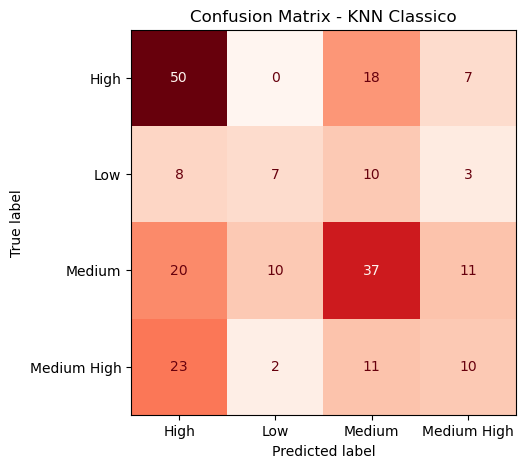

In [10]:
cm_classic = confusion_matrix(y_test_c, y_pred_c, labels=np.arange(len(le.classes_)))
plt.figure(figsize=(5, 5))
disp_c = ConfusionMatrixDisplay(confusion_matrix=cm_classic, display_labels=le.classes_)
disp_c.plot(cmap="Reds", colorbar=False, ax=plt.gca())
plt.xticks(rotation=0, ha='center')
plt.yticks(rotation=0)
plt.title("Confusion Matrix - KNN Classico")
plt.show()

=== KNN Classico - GridSearchCV ===
Best n_neighbors: 15
Best CV accuracy: 0.4741727885374294
              precision    recall  f1-score   support

        High       0.53      0.68      0.59        75
         Low       0.14      0.04      0.06        28
      Medium       0.47      0.67      0.55        78
 Medium High       0.33      0.09      0.14        46

    accuracy                           0.48       227
   macro avg       0.37      0.37      0.33       227
weighted avg       0.42      0.48      0.42       227



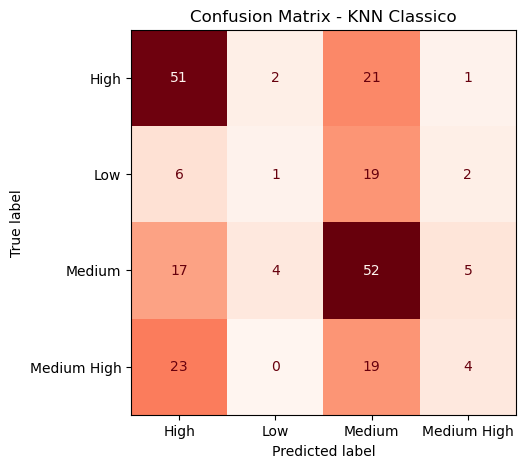

In [11]:
# GridSearchCV per KNN classico
param_grid_classic = {'n_neighbors': list(range(1, 16))}
grid_c = GridSearchCV(KNeighborsClassifier(), param_grid_classic, cv=5, scoring='accuracy')
grid_c.fit(X_train_c, y_train_c)

print("=== KNN Classico - GridSearchCV ===")
print("Best n_neighbors:", grid_c.best_params_['n_neighbors'])
print("Best CV accuracy:", grid_c.best_score_)

y_pred_c_opt = grid_c.best_estimator_.predict(X_test_c)
print(classification_report(y_test_c, y_pred_c_opt, target_names=le.classes_))

cm_classic = confusion_matrix(y_test_c, y_pred_c_opt, labels=np.arange(len(le.classes_)))
plt.figure(figsize=(5, 5))
disp_c = ConfusionMatrixDisplay(confusion_matrix=cm_classic, display_labels=le.classes_)
disp_c.plot(cmap="Reds", colorbar=False, ax=plt.gca())
plt.xticks(rotation=0, ha='center')
plt.yticks(rotation=0)
plt.title("Confusion Matrix - KNN Classico")
plt.show()

In [12]:
# ================================
# KNN DTW
# ================================
scaler_dtw = TimeSeriesScalerMeanVariance()
X_dtw_scaled = scaler_dtw.fit_transform(X_ts_log)  # shape: (n_samples, series_length, 1)

X_train_dt, X_test_dt, y_train_dt, y_test_dt = train_test_split(
    X_dtw_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

=== KNN DTW con n_neighbors = 15 ===
              precision    recall  f1-score   support

        High       0.47      0.60      0.53        75
         Low       0.56      0.18      0.27        28
      Medium       0.40      0.54      0.46        78
 Medium High       0.26      0.11      0.15        46

    accuracy                           0.43       227
   macro avg       0.42      0.36      0.35       227
weighted avg       0.42      0.43      0.40       227



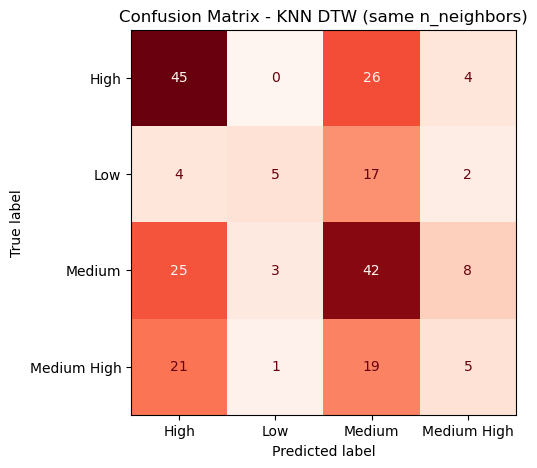

In [13]:
# Supponiamo che k_opt sia il numero di vicini trovato dal KNN classico
k_opt = grid_c.best_params_['n_neighbors']

# KNN DTW con lo stesso numero di vicini
knn_dtw_opt = KNeighborsTimeSeriesClassifier(
    n_neighbors=k_opt,
    metric="dtw",
    metric_params={"sakoe_chiba_radius": 7}
)

# Addestramento
knn_dtw_opt.fit(X_train_dt, y_train_dt)

# Predizione
y_pred_dt_opt = knn_dtw_opt.predict(X_test_dt)

# Classification report
print("=== KNN DTW con n_neighbors = {} ===".format(k_opt))
print(classification_report(y_test_dt, y_pred_dt_opt, target_names=le.classes_))

# Confusion matrix
cm_dtw = confusion_matrix(y_test_dt, y_pred_dt_opt, labels=np.arange(len(le.classes_)))
plt.figure(figsize=(5, 5))
disp_dt = ConfusionMatrixDisplay(confusion_matrix=cm_dtw, display_labels=le.classes_)
disp_dt.plot(cmap="Reds", colorbar=False, ax=plt.gca())
plt.xticks(rotation=0, ha='center')
plt.yticks(rotation=0)
plt.title("Confusion Matrix - KNN DTW (same n_neighbors)")
plt.show()

In [16]:
# Prendi solo un sottoinsieme del train set per il test rapido
subset_size = 200  # puoi aumentare o diminuire
X_train_dt_sub = X_train_dt[:subset_size]
y_train_dt_sub = y_train_dt[:subset_size]

X_test_dt_sub = X_test_dt[:50]  # pochi campioni per test rapido
y_test_dt_sub = y_test_dt[:50]


In [17]:
from tqdm import tqdm

neighbors_range = range(1, 11)
best_acc = 0
best_k = 1

print("=== Quick DTW grid search su sottoinsieme ===")
for k in tqdm(neighbors_range):
    knn_dt_temp = KNeighborsTimeSeriesClassifier(
        n_neighbors=k,
        metric="dtw",
        metric_params={"sakoe_chiba_radius": 7}
    )
    knn_dt_temp.fit(X_train_dt_sub, y_train_dt_sub)
    acc = knn_dt_temp.score(X_test_dt_sub, y_test_dt_sub)
    print(f"n_neighbors={k}, Test accuracy={acc:.4f}")
    if acc > best_acc:
        best_acc = acc
        best_k = k

print("\nBest n_neighbors stimato:", best_k)
print("Accuracy stimata sul subset:", best_acc)


=== Quick DTW grid search su sottoinsieme ===


 10%|█         | 1/10 [00:07<01:10,  7.86s/it]

n_neighbors=1, Test accuracy=0.2600


 20%|██        | 2/10 [00:15<01:02,  7.79s/it]

n_neighbors=2, Test accuracy=0.2600


 30%|███       | 3/10 [00:23<00:54,  7.73s/it]

n_neighbors=3, Test accuracy=0.2400


 40%|████      | 4/10 [00:30<00:46,  7.72s/it]

n_neighbors=4, Test accuracy=0.2400


 50%|█████     | 5/10 [00:38<00:38,  7.78s/it]

n_neighbors=5, Test accuracy=0.2800


 60%|██████    | 6/10 [00:46<00:31,  7.75s/it]

n_neighbors=6, Test accuracy=0.3200


 70%|███████   | 7/10 [00:54<00:23,  7.74s/it]

n_neighbors=7, Test accuracy=0.3400


 80%|████████  | 8/10 [01:01<00:15,  7.72s/it]

n_neighbors=8, Test accuracy=0.2800


 90%|█████████ | 9/10 [01:09<00:07,  7.72s/it]

n_neighbors=9, Test accuracy=0.3800


100%|██████████| 10/10 [01:17<00:00,  7.73s/it]

n_neighbors=10, Test accuracy=0.3400

Best n_neighbors stimato: 9
Accuracy stimata sul subset: 0.38


=== KNN DTW con n_neighbors = 9 ===
              precision    recall  f1-score   support

        High       0.48      0.59      0.53        75
         Low       0.42      0.18      0.25        28
      Medium       0.41      0.53      0.46        78
 Medium High       0.27      0.13      0.18        46

    accuracy                           0.42       227
   macro avg       0.39      0.36      0.35       227
weighted avg       0.40      0.42      0.40       227



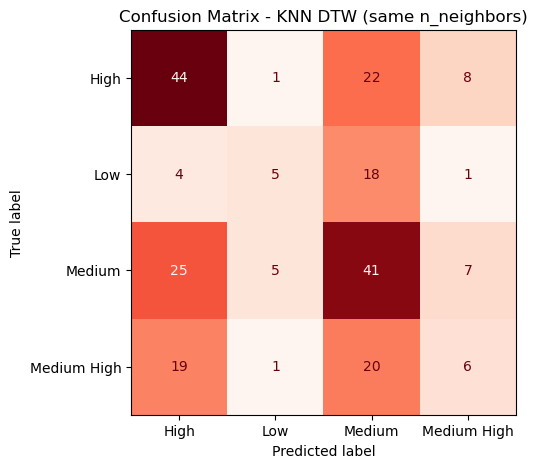

In [18]:
# Supponiamo che k_opt sia il numero di vicini trovato dal KNN classico
k_opt = 9

# KNN DTW con lo stesso numero di vicini
knn_dtw_opt = KNeighborsTimeSeriesClassifier(
    n_neighbors=k_opt,
    metric="dtw",
    metric_params={"sakoe_chiba_radius": 7}
)

# Addestramento
knn_dtw_opt.fit(X_train_dt, y_train_dt)

# Predizione
y_pred_dt_opt = knn_dtw_opt.predict(X_test_dt)

# Classification report
print("=== KNN DTW con n_neighbors = {} ===".format(k_opt))
print(classification_report(y_test_dt, y_pred_dt_opt, target_names=le.classes_))

# Confusion matrix
cm_dtw = confusion_matrix(y_test_dt, y_pred_dt_opt, labels=np.arange(len(le.classes_)))
plt.figure(figsize=(5, 5))
disp_dt = ConfusionMatrixDisplay(confusion_matrix=cm_dtw, display_labels=le.classes_)
disp_dt.plot(cmap="Reds", colorbar=False, ax=plt.gca())
plt.xticks(rotation=0, ha='center')
plt.yticks(rotation=0)
plt.title("Confusion Matrix - KNN DTW (same n_neighbors)")
plt.show()